# Data streaming

## Flow classification task – 1 A4

Group 97

Study paper 3 and construct a classifier for detecting anomalous behavior in individual NetFlows (every flow is a row, ignoring sequences). Do not forget to study and deal with properties of your data such as class imbalance. Evaluate your method in two ways: on the packet level (as in paper 3), and on the host level (as in paper 4). Do you prefer using a sequential model or a classifier for detecting botnets? Explain why.

We are using here the scenario 10 - CTU-Malware-Capture-Botnet-51

Per documentation, the distribution of labels in the NetFlows for scenario 10 (CTU-Malware-Capture-Botnet-51) in the dataset is:

Total flows | Botnet flows    | Normal flows  | C&C flows  | Background flows
------------|-----------------|---------------|------------|-------------------
1,309,791   | 106,315 (8.11%) | 15,847 (1.2%) | 37 (.002%) | 1,187,592 (90.67%)

- Infected hosts
    - 147.32.84.165: Windows XP English version Name: SARUMAN. Label: Botnet. Amount of bidirectional flows: 9579
    - 147.32.84.191: Windows XP English version Name: SARUMAN1. Label: Botnet. Amount of bidirectional flows: 10454
    - 147.32.84.192: Windows XP English version Name: SARUMAN2. Label: Botnet. Amount of bidirectional flows: 10397
    - 147.32.84.193: Windows XP English version Name: SARUMAN3. Label: Botnet. Amount of bidirectional flows: 10009
    - 147.32.84.204: Windows XP English version Name: SARUMAN4. Label: Botnet. Amount of bidirectional flows: 11159
    - 147.32.84.205: Windows XP English version Name: SARUMAN5. Label: Botnet. Amount of bidirectional flows: 11874
    - 147.32.84.206: Windows XP English version Name: SARUMAN6. Label: Botnet. Amount of bidirectional flows: 11287
    - 147.32.84.207: Windows XP English version Name: SARUMAN7. Label: Botnet. Amount of bidirectional flows: 10581
    - 147.32.84.208: Windows XP English version Name: SARUMAN8. Label: Botnet. Amount of bidirectional flows: 11118
    - 147.32.84.209: Windows XP English version Name: SARUMAN9. Label: Botnet. Amount of bidirectional flows: 9894
- Normal hosts:
    - 147.32.84.170 (amount of bidirectional flows: 10216, Label: Normal-V42-Stribrek)
    - 147.32.84.134 (amount of bidirectional flows: 1091, Label: Normal-V42-Jist)
    - 147.32.84.164 (amount of bidirectional flows: 3728, Label: Normal-V42-Grill)
    - 147.32.87.36 (amount of bidirectional flows: 99, Label: CVUT-WebServer. This normal host is not so reliable since is a webserver)
    - 147.32.80.9 (amount of bidirectional flows: 651, Label: CVUT-DNS-Server. This normal host is not so reliable since is a dns server)
    - 147.32.87.11 (amount of bidirectional flows: 4, Label: MatLab-Server. This normal host is not so reliable since is a matlab server)

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas.api.types import is_numeric_dtype
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns


np.random.seed(42)
random.seed(42)
%matplotlib inline

Reading the data file

In [2]:
# define filepath for scenario 10 dataset
filepath = './data/capture20110818.pcap.netflow.labeled'

# read data from the file
f = open(filepath, 'r')
lines = f.readlines()
f.close()
data = lines[1:] # drop the header

In [3]:
def preprocessing_remove_Background(data):
    '''data preprocessing
    Input
    -----
    data: string of a data flow
    
    Return
    ------
    o = None, if Background flow (to be removed)
    o = cleaned, formated data, if not Background flow
    '''
    if not 'Background' in data:
        s = data.split('\t')
        s = [x for x in s if x] # remove empty elements
        if len(s) < 12: # special fix for an outlier string @2011-08-18 12:18:31.264
            s = s[0].rsplit(' ', 11) 
        o = np.array([pd.to_datetime(s[0], format='%Y-%m-%d %H:%M:%S.%f'), # timestamp
                      float(s[1]), # duration
                      s[2], # protocol
                      s[3].split(':')[0], # ScrAddr
                      s[5].split(':')[0], # DstAddr
                      s[6].lstrip('_').rstrip('_').rstrip(), # flags
                      int(s[7]), # Tos
                      int(s[8]), # packets
                      int(s[9]), # bytes
                      int(s[10]), # flows
                      s[11].rstrip('\n').rstrip() # label
                     ])
    else: # if Background flow
        o = None
    return o

In [9]:
df = list(map(preprocessing_remove_Background, data)) # data preprocessing
df = [x for x in df if isinstance(x, np.ndarray)] # remove background flows
df = pd.DataFrame(df, columns=['Time', 'Duration', 'Protocol', 'ScrAddr', 'DstAddr', 
                               'Flags', 'Tos', 'Packets', 'Bytes', 'Flows', 'Label'])

Looking at the DataFrame

In [10]:
df.head()

,Time,Duration,Protocol,ScrAddr,DstAddr,Flags,Tos,Packets,Bytes,Flows,Label
0,2011-08-18 10:19:13.347,4.985,TCP,147.32.80.13,147.32.85.88,PA,0,91,86277,1,LEGITIMATE
1,2011-08-18 10:19:13.392,0.000,TCP,147.32.86.110,74.125.232.214,A,0,1,66,1,LEGITIMATE
2,2011-08-18 10:19:13.411,4.921,TCP,147.32.85.88,147.32.80.13,A,0,49,3234,1,LEGITIMATE
3,2011-08-18 10:19:13.460,4.742,TCP,147.32.84.59,74.125.108.208,A,0,118,7080,1,LEGITIMATE
4,2011-08-18 10:19:13.486,0.000,TCP,147.32.84.59,74.125.232.215,A,0,1,60,1,LEGITIMATE


## Fitting a ML Algorithm

#### Data Exploration - Verifying if the data is inbalanced

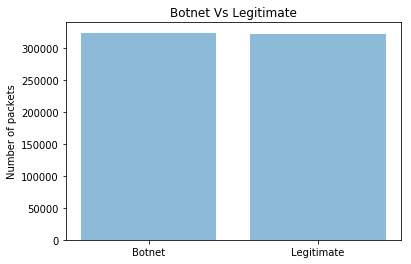

Percentage of Botnets/Total: 50.0%


In [54]:
len_labels = [len(df[df['Label']=="Botnet"]),len(df[df['Label']!="Botnet"])]

plt.bar(["Botnet","Legitimate"],len_labels, align='center', alpha=0.5)
plt.ylabel('Number of packets')
plt.title('Botnet Vs Legitimate')
plt.show()

print("Percentage of Botnets/Total: "+str(round(len(df[df['Label']=="Botnet"])/(len(df)),2)*100)+'%')

#### Data Preparation

In [12]:
pl_df = df.copy()

Dropping the columns that should not be used and separating the DF into features and labels

In [13]:
y = pl_df['Label']
X = pl_df.drop(columns=['Label','ScrAddr','DstAddr','Flows','Time'])
y=y.apply(lambda x: 0 if x=="LEGITIMATE" else 1)

#### Encoding

Checking variables to encode

In [14]:
X.dtypes
#X.value_counts()

Duration    float64
Protocol     object
Flags        object
Tos           int64
Packets       int64
Bytes         int64
dtype: object

Checking how many columns will be created

In [15]:
for column in X.columns:
    if is_numeric_dtype(X[column])==False:
        print(column+" | "+str(len(set(pl_df[column]))))

Protocol | 3
Flags | 73


Encoding

In [16]:
X=pd.get_dummies(X, columns=["Protocol", "Flags"], prefix=["Protocol", "Flags"])
X.head()

,Duration,Tos,Packets,Bytes,Protocol_ICMP,Protocol_TCP,Protocol_UDP,Flags_,Flags_A,Flags_AHA,...,Flags_URHTOS,Flags_URHU,Flags_URISO,Flags_URN,Flags_URNPRO,Flags_URNU,Flags_URP,Flags_URPRE,Flags_URS,Flags_WAY
0,4.985,0,91,86277,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.000,0,1,66,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4.921,0,49,3234,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4.742,0,118,7080,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000,0,1,60,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Scaling

Scaling the data

In [17]:
X.loc[:,["Duration","Packets","Bytes"]]=preprocessing.scale(X.loc[:,["Duration","Packets","Bytes"]])
X.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


,Duration,Tos,Packets,Bytes,Protocol_ICMP,Protocol_TCP,Protocol_UDP,Flags_,Flags_A,Flags_AHA,...,Flags_URHTOS,Flags_URHU,Flags_URISO,Flags_URN,Flags_URNPRO,Flags_URNU,Flags_URP,Flags_URPRE,Flags_URS,Flags_WAY
0,3.113642,0,0.597021,0.544271,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.449035,0,-0.134044,-0.100225,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3.067902,0,0.255857,-0.076542,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2.939975,0,0.816340,-0.047790,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.449035,0,-0.134044,-0.100270,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Separeting the datasets

Spliting the data into train and test set

In [18]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Split the train set into train and validation to use for parameter selection

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

#### Fitting the model

Running the loop to pick the best parameters in the train set (it takes some times, maybe a couple of hours)

In [20]:
f1_score = pd.DataFrame(columns=['Algorithm','N_neighbor/N_trees','F1'])
index=0
seed=42
n_neighbors = [1,3,5]
n_trees=[10,50,100,200]

for n_neighbor in n_neighbors:
        
    #Selecting the model and parameters
    model=KNeighborsClassifier(n_neighbors=n_neighbor, n_jobs=-1)
        
    #Learning the model and calculating the F1-score and saving in the DF
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    f1_score.loc[index]=["KNN",n_neighbor,metrics.f1_score(y_val, y_pred)]
    index += 1
        
        
for tree in n_trees:
        
    #Selecting the model and parameters
    model=RandomForestClassifier(n_estimators=tree, n_jobs=-1)
        
    #Learning the model and calculating the F1-score and saving in the DF
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    f1_score.loc[index]=["Random Forest",tree,metrics.f1_score(y_val, y_pred)]
    index += 1

Checking the best algorithm F1

In [21]:
f1_score.sort_values('F1', ascending=False).head(1)

,Algorithm,N_neighbor/N_trees,F1
4,Random Forest,50,0.994955


### Performance in the flow (packet) level

Making predictions in the test set the parameters and algorithm that perform the better in the train dataset

In [22]:
#Selecting the model and parameters
if f1_score.loc[f1_score["F1"].idxmax(),"Algorithm"] == "Random Forest":
    tree = f1_score.loc[f1_score["F1"].idxmax(),"N_neighbor/N_trees"]
    model = RandomForestClassifier(n_estimators=tree, n_jobs=-1)
    print("Using Random Forest with: " + str(tree) + " trees")
else:
    f1_score.loc[f1_score["F1"].idxmax(),"Algorithm"]["N_neighbor/N_trees"]
    n_neighbors = f1_score.loc[f1_score["F1"].idxmax(),"N_neighbor/N_trees"]
    model = KNeighborsClassifier(n_neighbors==n_neighbor, n_jobs=-1)
    print("Using KNN" + str(n_neighbors) + " neighbors")
    
#Learning the model and calculating the F1-score and saving in the DF
model.fit(X_train, y_train)

#Predicting
y_pred = model.predict(X_test)

Using Random Forest with: 50 trees


Ploting a Confusion Matrix

Recall: 0.9905393010625251
Precision: 0.9989918097534611
Accuracy: 0.9947574480393372
F1-Score: 0.9947476001966417


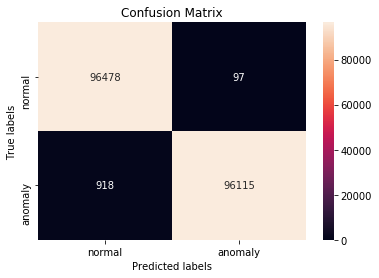

In [23]:
# Calculating the Confusion Matrix
cm=confusion_matrix(y_test, y_pred)

#Creating a function to plot in a nice format the CM and some performance indicators
def ploting_cm(cm):
    
    #Plot
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,fmt='g', ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['normal', 'anomaly']); ax.yaxis.set_ticklabels(['normal', 'anomaly'])
    
    # Performance
    tn, fp, fn, tp = cm.ravel()
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    accuracy=(tp+tn)/(tp+tn+fn+fp)
    f1=2*(precision*recall)/(precision+recall)
    print("Recall: " + str(recall))
    print("Precision: " + str(precision))
    print("Accuracy: " + str(accuracy))
    print("F1-Score: " + str(f1))
    
# Applying the function
ploting_cm(cm)

### Performance in the Host Level

The idea is to classify each host as botnet if it appears in at least one malicious flow as a source.

First we add a column with the prediction in the test set

In [24]:
# Adding the column with the predictions in the test set
X_test["Prediction"]=y_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Next we add the prediction in the original data frame

In [25]:
#Addding the prediction to a copy of the original DF
df_host=df.copy()
df_host["Prediction"]=0
for index, row in X_test.iterrows():
    df_host.loc[index,"Prediction"]=X_test.loc[index,"Prediction"]

#### Labling the predicted values: 
Now we add a new column named "Prediction_per_host" that will label all hosts that were a source of a malicous flow (as classified by the ML algorithm) as a botnet

In [29]:
df_grouped=pd.DataFrame(df_host.groupby("ScrAddr")["Prediction"].sum())
df_grouped.columns=["Prediction_per_host"]
df_grouped["Prediction_per_host"]=df_grouped["Prediction_per_host"].apply(lambda x: 0 if x==0 else 1)

#### Labeling the true labels for the hosts

In [30]:
df_grouped["ScrAddr"]=df_grouped.index
INFECTED_HOSTS = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193',
                  '147.32.84.204', '147.32.84.205', '147.32.84.206', '147.32.84.207', 
                  '147.32.84.208', '147.32.84.209']
df_grouped["Label"]=df_grouped["ScrAddr"].apply(lambda x: 1 if x in INFECTED_HOSTS  else 0)
df_grouped=df_grouped.drop(columns="ScrAddr")

Dropping the non-relevant hosts

In [58]:
df_grouped.index

Index(['10.10.20.233', '10.168.115.232', '10.168.48.160', '10.23.106.55',
       '10.23.12.43', '10.23.130.74', '10.23.139.192', '10.23.20.92',
       '10.23.24.236', '10.23.60.88',
       ...
       '93.152.160.101', '93.205.154.247', '94.112.88.183', '94.113.108.246',
       '94.199.40.135', '94.199.41.1', '95.103.17.209', '95.108.158.245',
       '95.211.77.153', '95.27.206.21'],
      dtype='object', name='ScrAddr', length=522)

Calculating performance metrics considering all the hosts

Recall: 1.0
Precision: 0.136986301369863
Accuracy: 0.8793103448275862
F1-Score: 0.24096385542168672


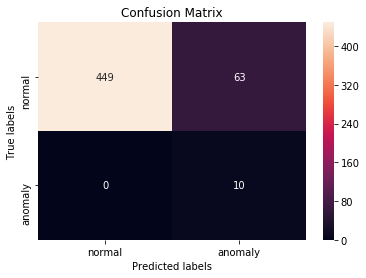

In [69]:
# Calculating the Confusion Matrix
cm=confusion_matrix(list(df_grouped["Label"]), list(df_grouped["Prediction_per_host"]))

#Creating a function to plot in a nice format the CM and some performance indicators
def ploting_cm(cm):
    
    #Plot
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,fmt='g', ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['normal', 'anomaly']); ax.yaxis.set_ticklabels(['normal', 'anomaly'])
    
    # Performance
    tn, fp, fn, tp = cm.ravel()
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    accuracy=(tp+tn)/(tp+tn+fn+fp)
    f1=2*(precision*recall)/(precision+recall)
    print("Recall: " + str(recall))
    print("Precision: " + str(precision))
    print("Accuracy: " + str(accuracy))
    print("F1-Score: " + str(f1))
    
# Applying the function
ploting_cm(cm)

Calculating performance metrics considering only the hosts in the documentation (check https://www.stratosphereips.org/datasets-ctu13 for more information)

Recall: 1.0
Precision: 0.7142857142857143
Accuracy: 0.7333333333333333
F1-Score: 0.8333333333333333


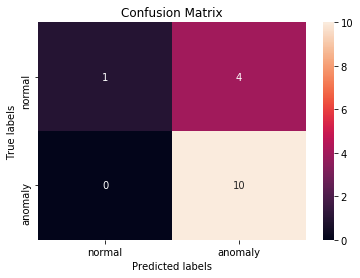

In [67]:
# Filtering the hsots
normal_hosts = ['147.32.84.170', '147.32.84.134', '147.32.84.164',
                '147.32.87.36', '147.32.80.9'] # 147.32.87.11 is removed as it contains very limited data flows
df_host_in_doc = df_grouped[df_grouped.index.isin(normal_hosts+INFECTED_HOSTS)]

# Calculating the Confusion Matrix
cm=confusion_matrix(list(df_host_in_doc["Label"]), list(df_host_in_doc["Prediction_per_host"]))
# Ploting the CM
ploting_cm(cm)